In [1]:
import numpy as np
from scipy.linalg import sqrtm
import scipy as sc
import qiskit
import random
import matplotlib.pyplot as plt
import scipy
import qiskit.providers.aer.noise as noise

from qiskit.quantum_info import Statevector
from qiskit.extensions import HamiltonianGate
from qiskit.circuit.library import MCMT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, Aer, IBMQ, execute

#from qiskit import IBMQ
#IBMQ.save_account('17d122182eb4e926eb789e55bc17a49c8e19335a70ee99a60213185d0a573876b81b71d8bd70adb55b8c0941b68ed8484b9218787ba2e1349edc2cdb9bbe0c9e')

from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz
from qiskit.algorithms.linear_solvers.observables import MatrixFunctional
from scipy.optimize import curve_fit
from qiskit.visualization import plot_histogram, plot_bloch_multivector
n_qubits=2

# Definition of the quantum gates

In [2]:
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
sigma=np.array([np.eye(2,dtype="complex"),X,Y,Z])
I=np.eye(2,dtype="complex")
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

# Actions on circuit (functions for qiskit library)

In [3]:
def qft(circuit, n=n_qubits, start=0, finish=n_qubits-1):
    """Performs qft from qubit start to qubit finish"""
    if n == 0 or finish==start:
        return circuit
    for i in range(int((finish-start+1)/2)):
        circuit.swap(start+i,finish-i)
    for qubit in range(start,finish+1):
        circuit.h(qubit)
        for pair in range(qubit+1,finish+1):
            circuit.cp(np.pi/2**(pair-qubit),qubit,pair)
    return circuit
def qft_d(circuit, n=n_qubits, start=0, finish=n_qubits-1):
    "QFT^\dagger"
    if n == 0 or finish==start:
        return circuit
    for qubit in range(finish,start-1,-1):
        circuit.h(qubit)
        for pair in range(qubit-1,start-1,-1):
            circuit.cp(-np.pi/2**(qubit-pair),qubit,pair)
            circuit.draw("mpl")
    for i in range(int((finish-start+1)/2)):
        circuit.swap(start+i,finish-i)
    return circuit
def qc_two_qubit(state): # return quantum circuit that prepare state from |00>
    if np.imag(state[0][0])>0.00000001:
        print("invalid state")
        return 0
    x1=2*np.arccos(np.sqrt(np.abs(state[0][0])**2+np.abs(state[1][0])**2))
    x2=np.angle(state[2][0])
    y1=2*np.arctan(np.abs((state[1][0]))/(np.abs(state[0][0])))
    y2=np.angle(state[1][0])
    z1=2*np.arccos(np.abs(state[2][0])/np.sqrt(1-np.abs(state[0][0])**2-np.abs(state[1][0])**2))-y1
    z2=np.angle(state[3][0])-np.angle(state[2][0])
    
    #CU3gate(z1,z2,-y2)@np.kron(U3gate(x1,x2,0),U3gate(y1,y2,0)) 
    parameters=np.array([x1,x2,0,y1,y2,0,z1,z2,-y2])
    qc = QuantumCircuit(2)
    qc.u(parameters[0],parameters[1],parameters[2],0)
    qc.u(parameters[3],parameters[4],parameters[5],1)
    qc.cu(parameters[6],parameters[7],parameters[8],gamma=0,control_qubit=0,target_qubit=1)
    return qc    

# Numpy transformations

In [4]:
def get_psi(n_qubits): #Random state Haar measure
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    psi=psi/np.exp(1j*np.angle(psi[0][0]))
    return psi
def equal(a,b):
    return np.linalg.norm(a-b)<0.000001 #проверка равентства матриц
def is_unitary(matrix):
    if(np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))<0.00001):
        return True
    return np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
def is_hermit(matrix): #return True if matrix is hermitian
    return np.linalg.norm(matrix.T.conjugate()-matrix)<0.0000001
def trace(a):
    return np.trace(a)/len(a)
def convert_base(value, base, length=16,n_qubits=n_qubits):# меняет систему исчесления
    if value < 0:
        value = ( 1<<length ) + value
 
    res = ''
    while value > 0:
        res = str(value % base) + res
        value //= base
    while len(res)<n_qubits:
        res="0"+res
    return res
def decompose(A,n_qubits=n_qubits): # разложение на строчки Паули
    parameters=np.array([])
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        parameters=np.append(parameters,trace(A@a))
    return parameters
def compose(parameters,n_qubits=n_qubits): # сборка по параметрам разложения
    A=np.zeros((2**n_qubits,2**n_qubits),dtype="complex")
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        A=A+parameters[i]*a
    return A
def Pauli_system(a): #Auxiliary function for Pauli strings decomposition
    Pauli_string=''
    for i in range(len(a)):
        if a[i]=='0':
            Pauli_string+="I"
        if a[i]=="1":
            Pauli_string+="X"
        if a[i]=="2":
            Pauli_string+="Y"
        if a[i]=="3":
            Pauli_string+="Z"
    return Pauli_string 
def write_decomposition(parameters,n_qubits=n_qubits): #write decomposition to Pauli strings and return non-zero strings
    a=""
    b=""
    for i in range(len(parameters)):
        if np.abs(parameters[i])>0.00001:
            if np.imag(parameters[i])==0:
                if np.real(parameters[i])>0:
                    print("+ "+str(np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            elif np.real(parameters[i])==0:
                if np.imag(parameters[i])>0:
                    print("+ "+str(np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ") 
            else:
                if np.imag(parameters[i])>0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"+ "+str(np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])<0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"- "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])>0 and np.real(parameters[i])<0:
                    print("+ (-"+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- ("+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            b+=Pauli_system(convert_base(i,4,n_qubits=n_qubits))+";"
    return b.split(";")[:-1:]
def Unitaries(decomposition,n_qubits=n_qubits): #return matrices in decomposition (first use decompose function)
    Unit=np.eye(2**n_qubits,dtype="complex")
    for i in range(1,len(decomposition)):
        if decomposition[i]!=0:
            a=sigma[int(convert_base(i,4)[0])]
            for j in range(1,n_qubits):
                a=np.kron(a,sigma[int(convert_base(i,4)[j])])
            Unit=np.append(Unit,a,axis=0)
    return np.reshape(Unit,(len(decomposition[decomposition!=0]),2**n_qubits,2**n_qubits))
def h_decompose(matrix): #decompose a matrix to sum of the 2 hermitian operators
    H1=0.5*(matrix+matrix.T.conjugate())
    H2=-0.5j*(matrix-matrix.T.conjugate())
    if is_hermit(H1) and is_hermit(H2):
        return H1,H2
    else:
        return False
def u_decompose(A): #decompose a hermitian matrix to sum of 2 unitaries
    U1=A+1j*sqrtm(np.eye(len(A))-A@A)
    U2=A-1j*sqrtm(np.eye(len(A))-A@A) 
    if is_unitary(U1) and is_unitary(U2):
        return U1,U2
    else:
        return False
def Rx(theta):
    return np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],[-1j*np.sin(theta/2),np.cos(theta/2)]])
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def L(n=n_qubits):
    matrix=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        matrix[i][i-1]=1
    return matrix
def U3gate(x,y,z):
    return np.array([[np.cos(x/2),(-1)*np.exp(1j*z)*np.sin(x/2)],[np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def CU3gate(x,y,z):
    return np.array([[1,0,0,0],[0,1,0,0],[0,0,np.cos(x/2),-np.exp(1j*z)*np.sin(x/2)],[0,0,np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def two_qubit_state(state):
    if np.imag(state[0][0])>0.00000001:
        print("invalid state")
        return 0
    x1=2*np.arccos(np.sqrt(np.abs(state[0][0])**2+np.abs(state[1][0])**2))
    x2=np.angle(state[2][0])
    y1=2*np.arctan(np.abs((state[1][0]))/(np.abs(state[0][0])))
    y2=np.angle(state[1][0])
    z1=2*np.arccos(np.abs(state[2][0])/np.sqrt(1-np.abs(state[0][0])**2-np.abs(state[1][0])**2))-y1
    z2=np.angle(state[3][0])-np.angle(state[2][0])
    return CU3gate(z1,z2,-y2)@np.kron(U3gate(x1,x2,0),U3gate(y1,y2,0))
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def rho_fidelity(a,b):
    fidelity=(np.trace(sqrtm(sqrtm(a)@b@sqrtm(a))))**2
    if np.abs(np.imag(fidelity))>0.0000001:
        print("error")
        return 0
    return np.real(fidelity)
def create_A(c,n_qubits=n_qubits):
    A=np.zeros((2**n_qubits,2**n_qubits),dtype=complex)
    for i in range(2**n_qubits):
        if i!=(2**n_qubits-1):
            A[i][i+1]=1
        if i!=0:
            A[i][i-1]=1
        A[i][i]=-2-c
    A[0][-1]=1
    A[-1][0]=1
    return A    

# Creation b

In [5]:
b_init = np.reshape(np.array([0]+[np.random.normal() for i in range(2**n_qubits-1)]) + 1j*np.array([0]+[np.random.normal() for i in range(2**n_qubits-1)]), (2**n_qubits,1))
b_init=b_init/(np.sqrt(b_init.conjugate().T@b_init))
b=QFT().T.conjugate()@b_init

In [6]:
#creation A
A=np.zeros((2**n_qubits,2**n_qubits)) #cycle
A_free=np.zeros((2**n_qubits,2**n_qubits)) #non cycle
for i in range(2**n_qubits):
    A[i][i]=-2;
    A_free[i][i]=-2
    if i!=0:
        A[i][i-1]=1
        A_free[i][i-1]=1
    if i!=2**n_qubits-1:
        A[i][i+1]=1
        A_free[i][i+1]=1
    A[0][-1]=1
    A[-1][0]=1
A_norm=np.linalg.norm(A)
A_F=QFT()@A@(QFT().T.conjugate())
#A=A/A_norm
#finding solution
val,vec=np.linalg.eigh(A)
val=np.array([1/val[i] for i in range(len(val)-1)])
val=np.append(val,0.)
A_inv=vec@np.diag(val)@vec.T #псевдообратная
x=A_inv@b # решение
print(np.linalg.norm(A@x-b)<0.0000001)# проверка найденного решения
x=x/np.sqrt(x.T.conjugate()@x)

True


# Substitution of the spectrum of the matrix A in the fourier space

In [7]:
A_new_F_shift=np.diag(np.array([-4*(np.pi*i/2**n_qubits-np.pi/2)**2 for i in range(2**n_qubits)]))
A_new_F=A_new_F_shift
for i in range(2**(n_qubits-1)):
    A_new_F=L()@A_new_F@(L().T.conjugate())
A_new=QFT().T.conjugate()@A_new_F@QFT()
D=np.diag(A_new_F)
write_decomposition(np.round(decompose(A_new_F),1))
print("\n")
write_decomposition(np.round(decompose(A_F),1))
val,vec=np.linalg.eigh(A_new)
val=np.array([1/val[i] for i in range(len(val)-1)])
val=np.append(val,0.)
A_new_1=vec@np.diag(val)@vec.T #псевдообратная
x_new=A_new_1@b
x_new=x_new/np.sqrt(x_new.T.conjugate()@x_new)

- 3.7 II - 1.2 IZ + 2.5 ZI + 2.5 ZZ 

- 2.0 II + 1.0 ZI + 1.0 ZZ 

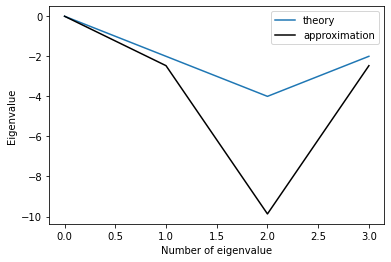

In [8]:
plt.plot(np.diag(np.real(A_F)))
plt.plot(np.real(np.diag(A_new_F)),color="black")
plt.legend(["theory","approximation"])
plt.xlabel("Number of eigenvalue")
plt.ylabel("Eigenvalue")
plt.show()

In [9]:
x #True solution

array([[-0.13181832+0.43377793j],
       [-0.27436541+0.06734269j],
       [-0.11008732-0.64453573j],
       [ 0.51627105+0.1434151j ]])

In [10]:
x_new #solution for matrix A_new

array([[-0.07426627+0.50640806j],
       [-0.34856725+0.01525389j],
       [-0.0516445 -0.61610653j],
       [ 0.47447803+0.09444457j]])

In [11]:
print("100% error level ="+str((np.abs(b.T.conjugate()@x_new)**2)[0][0]))

100% error level =0.8279739085614687


In [12]:
(np.abs(x.T.conjugate()@x_new)**2)[0][0] # Fidelity of solutions

0.974983362482553

# Optimization classical

In [13]:
set_u=write_decomposition(np.round(decompose(A_new_F),3))
def x_s(alpha,b=b):
    wave_function=alpha[0]*b+alpha[1]*(QFT(2).T.conjugate())@np.kron(I,Z)@QFT(2)@b+alpha[2]*(QFT(2).T.conjugate())@np.kron(Z,I)@QFT(2)@b+alpha[3]*(QFT(2).T.conjugate())@np.kron(Z,Z)@QFT(2)@b
    #wave_function=wave_function/np.sqrt(wave_function.T.conjugate()@wave_function)
    return wave_function
#def x_angles(alpha,b=b):
#    wave_function=np.cos(alpha[0])*np.cos(alpha[1])*b+np.cos(alpha[0])*np.sin(alpha[1])*np.exp(1j*alpha[3])*(QFT(2).T.conjugate())@np.kron(I,Z)@QFT(2)@b+np.sin(alpha[0])*np.cos(alpha[2])*np.exp(1j*alpha[4])*(QFT(2).T.conjugate())@np.kron(Z,I)@QFT(2)@b+np.cos(alpha[0])*np.sin(alpha[2])*np.exp(1j*alpha[5])*(QFT(2).T.conjugate())@np.kron(Z,Z)@QFT(2)@b
#    wave_function=wave_function/np.sqrt(wave_function.T.conjugate()@wave_function)
#    return wave_function
def function(alpha,b=b): # function that will be optimized
    x=x_s(alpha,b=b)
    return np.abs(((x.T.conjugate())@(A_new.T.conjugate())@A_new@x)-(2*np.real(b.T.conjugate()@A_new@x))+1)[0][0]    
set_u

- 3.701 II - 1.234 IZ + 2.467 ZI + 2.467 ZZ 

['II', 'IZ', 'ZI', 'ZZ']

In [22]:
x_opt=x_s(sc.optimize.minimize(function,np.array([0 for i in range(4)]),method='Powell').x) # solution for A_new obtained using classcial optimization
x_opt=x_opt/np.sqrt(x_opt.T.conjugate()@x_opt)
print(sc.optimize.minimize(function,np.array([0 for i in range(4)]),method='Powell').fun)
(np.real(x_opt.T.conjugate()@x_new)**2)[0][0] # Fidelity of solutions

0.0


0.9999999999999998

# Error analysis (IBMQ)

In [ ]:
#provider = IBMQ.load_account()
qasm_sim = Aer.get_backend('qasm_simulator')
#qasm_sim = Aer.get_backend('qasm_simulator')
method="Powell" #metod of the optimization on quantum simulator
shots = 5000
set_u

In [ ]:
# Error probabilities
prob_1 = 0  # 1-qubit gate
prob_2 = prob_1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3','u','h','z','x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cz','cu'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [ ]:
#measurement (quantum simulator)
def psi_A_b_error(psi,noise_model,basis_gates,D=D,n_qubits=n_qubits,b_init=b_init,shots=shots): #compute <psi|A|b>
    qr=QuantumRegister(n_qubits+1)
    qc=QuantumCircuit(qr)
    qc.h(0)
    qc.x(0)
    qc=qc.compose(qc_two_qubit(b_init),qubits=[1,2])
    for i in range(len(psi)):
        if psi[i]=="Z":
            qc.cz(0,1+i)
    qc.x(0)
    qc.h(0)
    qc.measure_all()
    results = execute(qc, qasm_sim,
                 basis_gates=basis_gates,
                 noise_model=noise_model,shots=shots).result()
    answer = results.get_counts()
#    print(psi,end="\t")
    mean=0
    for j in answer:
        #answer[j]=1
        mean+=answer[j]*D[int((j[::-1])[1:3:],2)]*((-1)**int(j[-1],2))
#    print(answer)
    return mean/shots
D2=D**2# eigenvalues for A^2
def psi_A2_psi_i_error(psi,psi_i,noise_model,basis_gates,D2=D2,n_qubits=n_qubits,b_init=b_init,shots=shots): #compute <psi|A^2|psi_i>
    qr=QuantumRegister(n_qubits+1)
    qc=QuantumCircuit(qr)
    qc.h(0)
    qc=qc.compose(qc_two_qubit(b_init),qubits=[1,2])
    for i in range(len(psi)):
        if psi[i]=="Z":
            qc.z(1+i)
    for i in range(len(psi)):
        if (psi_i[i]=="Z" and psi[i]=="I"):
            qc.cz(0,1+i)
        elif (psi[i]=="Z" and psi_i[i]=="I"):
            qc.cz(0,1+i)
    qc.h(0)
    qc.measure_all()
    results = execute(qc, qasm_sim,
                 basis_gates=basis_gates,
                 noise_model=noise_model,shots=shots).result()
    answer = results.get_counts()
#    print(psi+psi_i,end="\t")
    mean=0
    for j in answer:
        #answer[j]=1
        mean+=answer[j]*D2[int((j[::-1])[1:3:],2)]*((-1)**int(j[-1],2))
#    print(answer)
    return mean/shots

def x_A_A_x_error(x,measure): # compute <x|AA|x> (x["ZI"]=coefficient))
    solution=0
    for i in x:
        for j in x:
            solution+=x[i]*(np.conjugate(x[j]))*measure[i+j]
    return np.real(solution)
def Re_b_A_x_error(x,measure):# compute Re(<b|A|x>)
    solution=0
    for i in x:
        solution+=x[i]*measure[i]
    return np.real(solution)

# Without error

In [ ]:
%%time
def measurement(b_try,noise_model,set_u=set_u,shots=shots,basis_gates=basis_gates):
    measure={}
    for i in set_u:
        measure[i]=psi_A_b_error(i,noise_model=noise_model,basis_gates=basis_gates,b_init=b_try,shots=2*shots)
        for j in set_u:
            measure[i+j]=psi_A2_psi_i_error(j,i,noise_model=noise_model,basis_gates=basis_gates,b_init=b_try,shots=2*shots)
    return measure

def lossfunction_error(alpha,measure):
    x={"II":alpha[0],"IZ":alpha[1],"ZI":alpha[2],"ZZ":alpha[3]}
    return x_A_A_x_error(x,measure)-2*Re_b_A_x_error(x,measure)+1
measure=measurement(b_init,noise_model)
#optimization
bound=0.5
x_quantum_error_s=sc.optimize.minimize((lambda x: lossfunction_error(x,measure=measure)),[0,0,0,0],method=method,bounds=[(-bound,-0),(0,bound),(-bound,0),(0,bound)]) # solution for A_new obtained using quantum simulator
x_quantum_error=x_s(x_quantum_error_s.x)
print("100% error level ="+str((np.abs(b.T.conjugate()@x_new)**2)[0][0]))
x_quantum_error=x_quantum_error/np.sqrt(x_quantum_error.T.conjugate()@x_quantum_error)
print("Fidelity of solutions ="+str((np.abs(x_new.T.conjugate()@x_quantum_error)**2)[0][0]))

# Depolarization noise analysis

In [ ]:
# %%time
# error_probability=np.linspace(0,0.1,50)
# Fidelity_samples=np.array([])
# count=0
# for error in error_probability:
#     samples=np.array([])
    
#     # Error probabilities
#     prob_1 = error  # 1-qubit gate
#     prob_2 = prob_1   # 2-qubit gate

#     # Depolarizing quantum errors
#     error_1 = noise.depolarizing_error(prob_1, 1)
#     error_2 = noise.depolarizing_error(prob_2, 2)

#     # Add errors to noise model
#     noise_model = noise.NoiseModel()
#     noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3','u','h','z','x'])
#     noise_model.add_all_qubit_quantum_error(error_2, ['cz','cu'])

#     # Get basis gates from noise model
#     basis_gates = noise_model.basis_gates

#     for initial in range(20):
#         # random b_init
#         b_try=np.reshape(np.array([0]+[np.random.normal() for i in range(2**n_qubits-1)]) + 1j*np.array([0]+[np.random.normal() for i in range(2**n_qubits-1)]), (2**n_qubits,1))
#         b_try=b_try/(np.sqrt(b_try.conjugate().T@b_try))# normalization
#         b_try_f=QFT().T.conjugate()@b_try # b determination
        
#         measure=measurement(b_try,noise_model,basis_gates=basis_gates) # measurements using quantum simulator
        
#         x_try=A_new_1@b_try_f #True solution for b_try
#         x_try=x_try/np.sqrt(x_try.T.conjugate()@x_try) # normalization
        
#         #optimization
#         bound=2 # bound parameter for optimization
        
#         x_quantum_error_s=sc.optimize.minimize((lambda x: lossfunction_error(x,measure)),[0,0,0,0],method=method,bounds=[(-bound,0),(0,bound),(-bound,0),(0,bound)]) # solution for A_new obtained using quantum simulator
#         x_quantum_error=x_s(x_quantum_error_s.x,b=b_try_f)
#         x_quantum_error=x_quantum_error/np.sqrt(x_quantum_error.T.conjugate()@x_quantum_error) #normalization
        
#         samples=np.append(samples,(np.abs(x_try.T.conjugate()@x_quantum_error)**2)[0][0]) # Fidelity of solutions

#     Fidelity_samples=np.append(Fidelity_samples,samples.mean())
#     if count!=0:
#         print("\b"*len(str(count)),end="")
#     count+=2
#     print(count,end="")
    

In [ ]:
# plt.plot(error_probability,Fidelity_samples,'o')
# plt.xlabel("Error probability")
# plt.ylabel("Fidelity")
# plt.show()

# DEBUG

In [ ]:
# Fidelity_samples

In [ ]:
# file = open("error_dependence_Poisson.txt", "w")
# for i in range(len(Fidelity_samples)):
#     file.write(str(Fidelity_samples[i])+" "+str(error_probability[i])+"\n")
# file.close()